In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap.umap_ as umap
%matplotlib inline

Making 4dimensional data visualizable:

In [2]:
#Seed for consitency in testing
np.random.seed(42)
data = np.random.rand(800, 4)

In [3]:
#Low Dimensional fit for the data
fit = umap.UMAP()
%time u = fit.fit_transform(data)

CPU times: user 6.38 s, sys: 1.14 s, total: 7.52 s
Wall time: 4.75 s


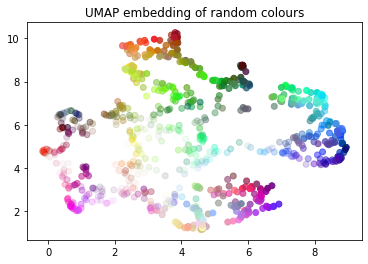

In [4]:
#Using 2d U var to scatter color data from 4d source data
plt.scatter(u[:,0], u[:,1], c=data)
plt.title('UMAP embedding of random colours');


Umap has several hyperparameters:

In [5]:
#Utility Function to fit data with UMAP given sets of parametr choices
#Plotting results
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
    plt.title(title, fontsize=18)

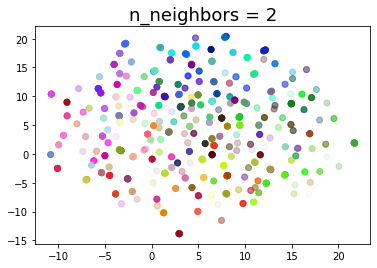

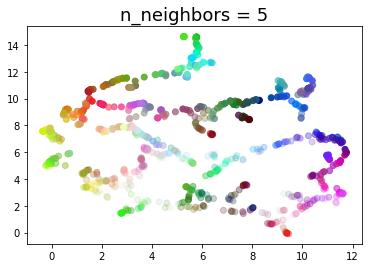

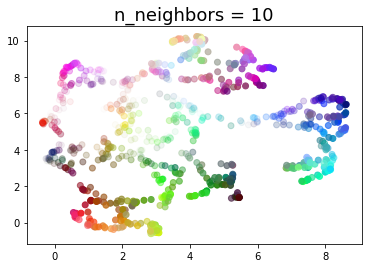

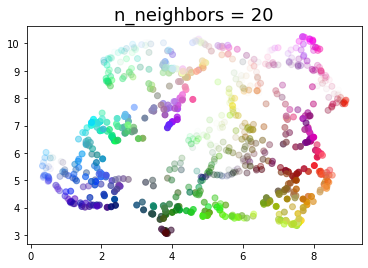

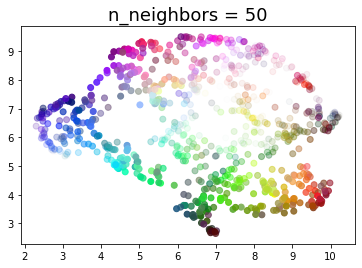

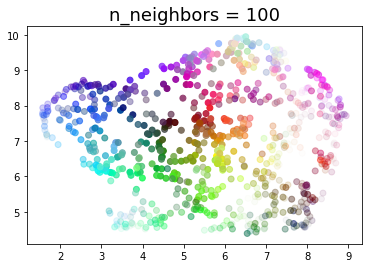

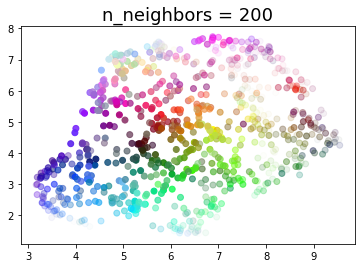

In [7]:
#n_neighbors
for n in (2,5,10,20,50,100,200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

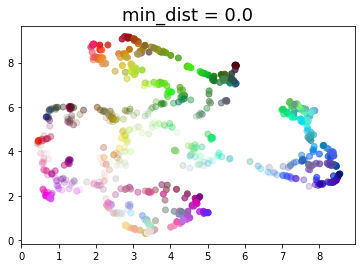

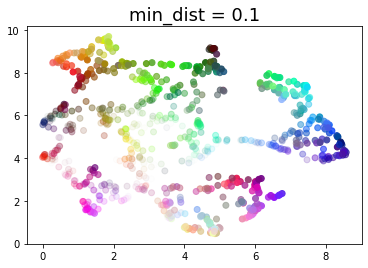

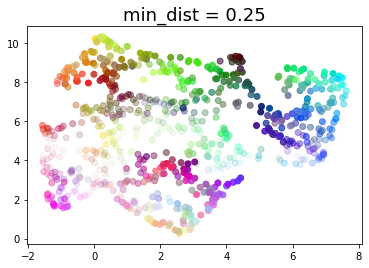

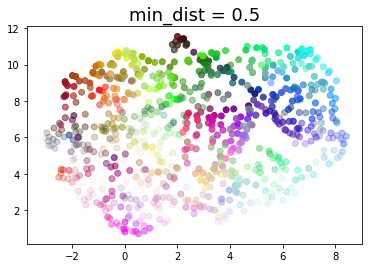

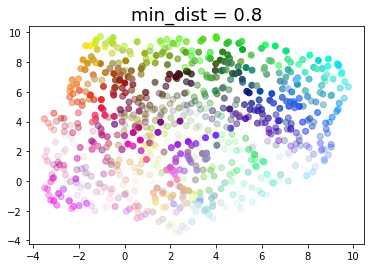

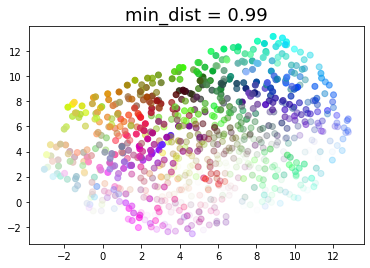

In [8]:
#min_dist
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

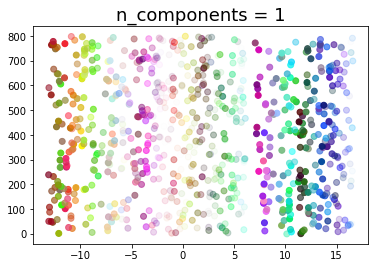

In [9]:
#n_components
#Components represnting determined dimensional representation
draw_umap(n_components=1, title='n_components = 1')

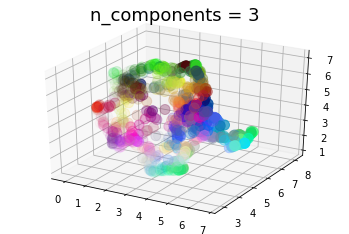

In [14]:
draw_umap(n_components=3, title='n_components = 3')

In [16]:
#metric
#(i.e) Minkowski style, rand. spatial, norm. spatial,
#Angular & Correlation, Bindary metrics
#specified through metric = '<metric name>'(i.e(metric='cosine'))

import numba
#for first custom metric we define distance as an absolute value
# of difference in red channel(1)
@numba.njit()
def red_channel_dist(a,b):
    return np.abs(a[0] - b[0])

In [17]:
#for more complexity usefulness is in colorspace conversion
#Simply now just use HSL formulas for extracting attributes 
#from an (R,G,B) tuple 
@numba.njit()
def hue(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    delta = cmax - cmin
    if cmax == r:
        return ((g - b) / delta) % 6
    elif cmax == g:
        return ((b - r) / delta) + 2
    else:
        return ((r - g) / delta) + 4

@numba.njit()
def lightness(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    return (cmax + cmin) / 2.0

@numba.njit()
def saturation(r, g, b):
    cmax = max(r, g, b)
    cmin = min(r, g, b)
    chroma = cmax - cmin
    light = lightness(r, g, b)
    if light == 1:
        return 0
    else:
        return chroma / (1 - abs(2*light - 1))

In [18]:
#Now we can define three extra distances

#Difference in hue
@numba.njit()
def hue_dist(a, b):
    diff = (hue(a[0], a[1], a[2]) - hue(b[0], b[1], b[2])) % 6
    if diff < 0:
        return diff + 6
    else:
        return diff
    
#Euclidean distance in combines saturation and lightness space
@numba.njit()
def sl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2

#Distance in the full HSL space
@numba.njit()
def hsl_dist(a, b):
    a_sat = saturation(a[0], a[1], a[2])
    b_sat = saturation(b[0], b[1], b[2])
    a_light = lightness(a[0], a[1], a[2])
    b_light = lightness(b[0], b[1], b[2])
    a_hue = hue(a[0], a[1], a[2])
    b_hue = hue(b[0], b[1], b[2])
    return (a_sat - b_sat)**2 + (a_light - b_light)**2 + (((a_hue - b_hue) % 6) / 6.0)

/Users/shaan.s.patel/.local/lib/python3.7/site-packages/umap_learn-0.5.1-py3.7.egg/umap/umap_.py:1744: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/Users/shaan.s.patel/.local/lib/python3.7/site-packages/umap_learn-0.5.1-py3.7.egg/umap/umap_.py:1744: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  "custom distance metric does not return gradient; inverse_transform will be unavailable. "
/Users/shaan.s.patel/.local/lib/python3.7/site-packages/umap_learn-0.5.1-py3.7.egg/umap/umap_.py:1744: UserWarning: custom dis

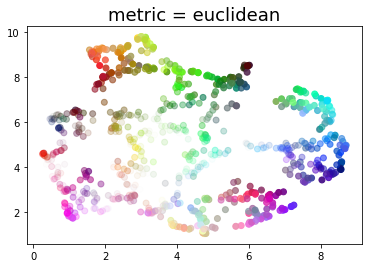

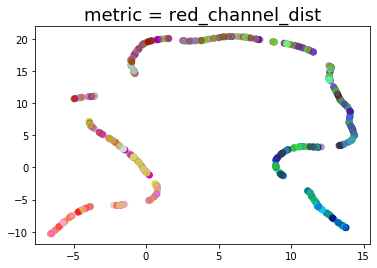

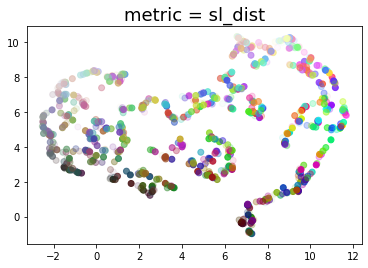

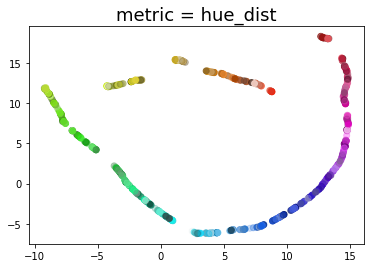

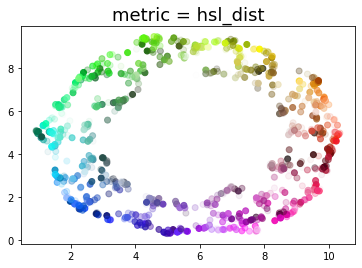

In [19]:
#Using custom metrics we can get UMAP to embed data using them
##Measuring distance between our input data points
for m in ("euclidean", red_channel_dist, sl_dist, hue_dist, hsl_dist):
    name = m if type(m) is str else m.__name__
    draw_umap(n_components=2, metric=m, title='metric = {}'.format(name))